<h1><center><b> MAGNET: A Lightweight DNN and SensorFusion based Time Series Classification for Indoor Outdoor Detection</center></h1></b>

<h2><b>  Author:</h2></b> 

        Bilal Dastagir     

## Mount Google Colab

In [64]:
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
    dataset_Path = '/content/gdrive/MyDrive/Datasets/'
    model_Path = '/content/gdrive/MyDrive/models/'
except:
    dataset_Path = '/home/bilz/air/Datasets/'
    model_Path = '/home/bilz/air/models/'
    

dataset_Path_Full = dataset_Path + 'trainingTestingMagnetData.csv'
DATA_PATH = dataset_Path_Full
print(DATA_PATH)

/home/bilz/air/Datasets/trainingTestingMagnetData.csv


In [65]:
version = 1
window_size = 6
epoch_number = 100
batch_number = 64
fold_number = 6
input_features = 8
outputs_class = 2

<h2><b>  Importing all the necessary libraries </h2></b> 

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import scipy.stats as stats
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
import seaborn as sns
import warnings
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from matplotlib.pyplot import figure
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
warnings.filterwarnings('ignore')
#Printing the version of TensorFlow in use
print(tf.__version__)  

2.11.0


## MAGNET: A Lightweight DNN and SensorFusion based Time Series Classification for Indoor Outdoor Detection .

<h2><b> Pre-processing of the Dataset </b></h2>

In [67]:
# load the original CSV file into a DataFrame
df = pd.read_csv(DATA_PATH)
print(df.head())

    index    state     timestamp      mag-z      mag-y      mag-x     acc-z  \
0  761582  Outdoor  1.680000e+18 -16.331251  13.443750  -1.912500  0.965152   
1   62060   Indoor  1.680000e+18 -15.993751 -38.887501   3.525000  7.594865   
2  507304   Indoor  1.680000e+18 -36.131252 -19.481251  23.831251  0.739519   
3   24590  Outdoor  1.680000e+18 -14.287500 -39.225002 -23.550001  0.866144   
4  156344   Indoor  1.680000e+18 -30.975000 -33.131252  33.281250 -0.086509   

      acc-y     acc-x    gyro-z    gyro-y    gyro-x  
0 -0.325462 -0.137631  0.057878  0.280684 -0.089413  
1 -0.948397  2.589142 -1.066539  0.461953 -0.993696  
2 -1.843896  2.091499 -0.187225 -0.204252 -0.042607  
3 -1.319489  0.095231  0.520442  0.410642 -1.430452  
4  0.645785 -0.043492 -0.869388 -0.371548 -0.304965  


In [68]:
columns = ['index','state','timestamp','mag-z','mag-y','mag-x','acc-z','acc-y','acc-x','gyro-z','gyro-y','gyro-x']
data = pd.DataFrame(data = df, columns = columns)
print('Shape of the data:', data.shape)
# Converting the string formatted data into float
data['mag-z'] = data['mag-z'].astype('float')
data['mag-y'] = data['mag-y'].astype('float')
data['mag-x'] = data['mag-x'].astype('float')
data['acc-z'] = data['acc-z'].astype('float')
data['acc-y'] = data['acc-y'].astype('float')
data['acc-x'] = data['acc-x'].astype('float')
data['gyro-z'] = data['gyro-z'].astype('float')
data['gyro-y'] = data['gyro-y'].astype('float')
data['gyro-x'] = data['gyro-x'].astype('float')
Fs = 20 # Number of Frames
states = data['state'].value_counts().index

Shape of the data: (1107510, 12)


### Ploting the Dataset

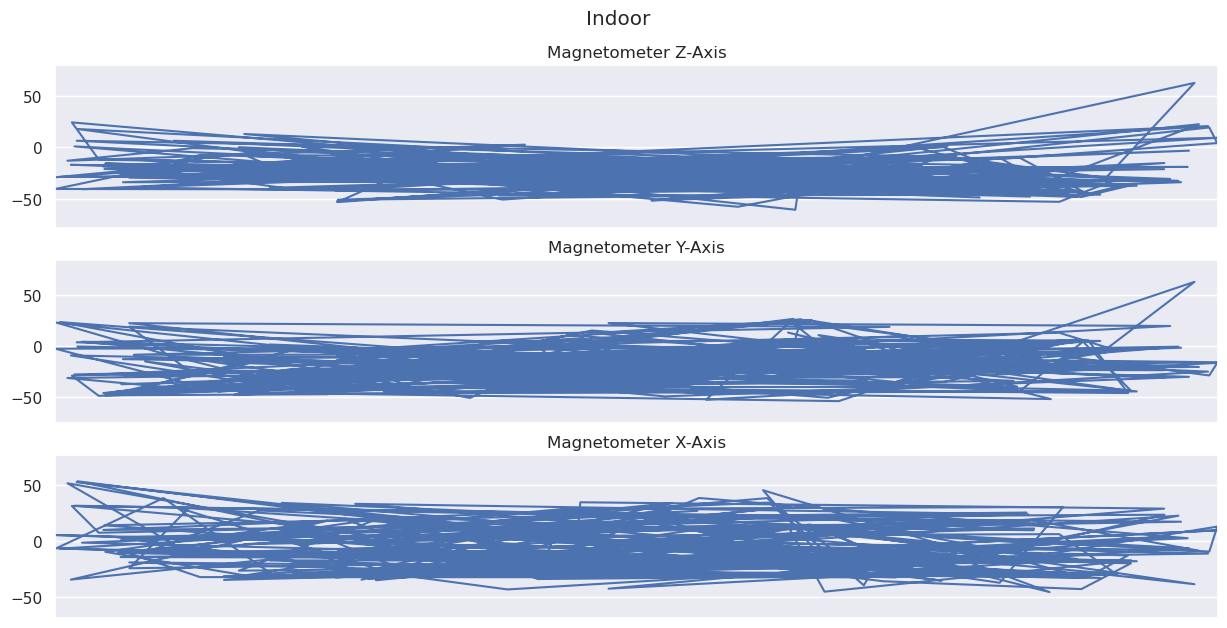

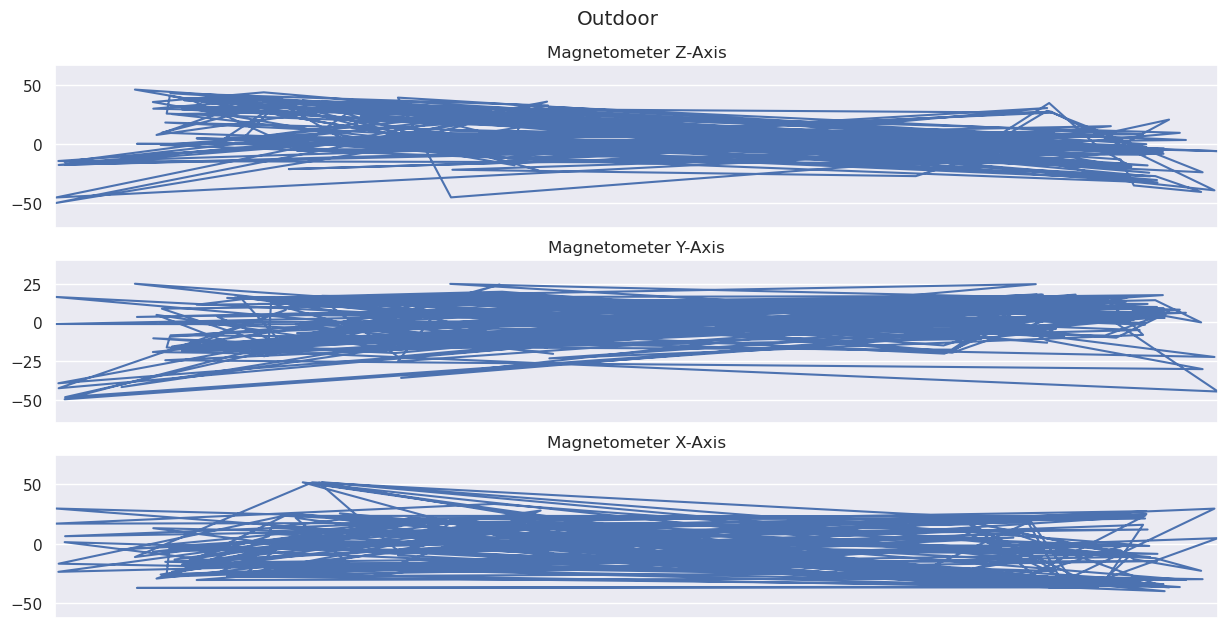

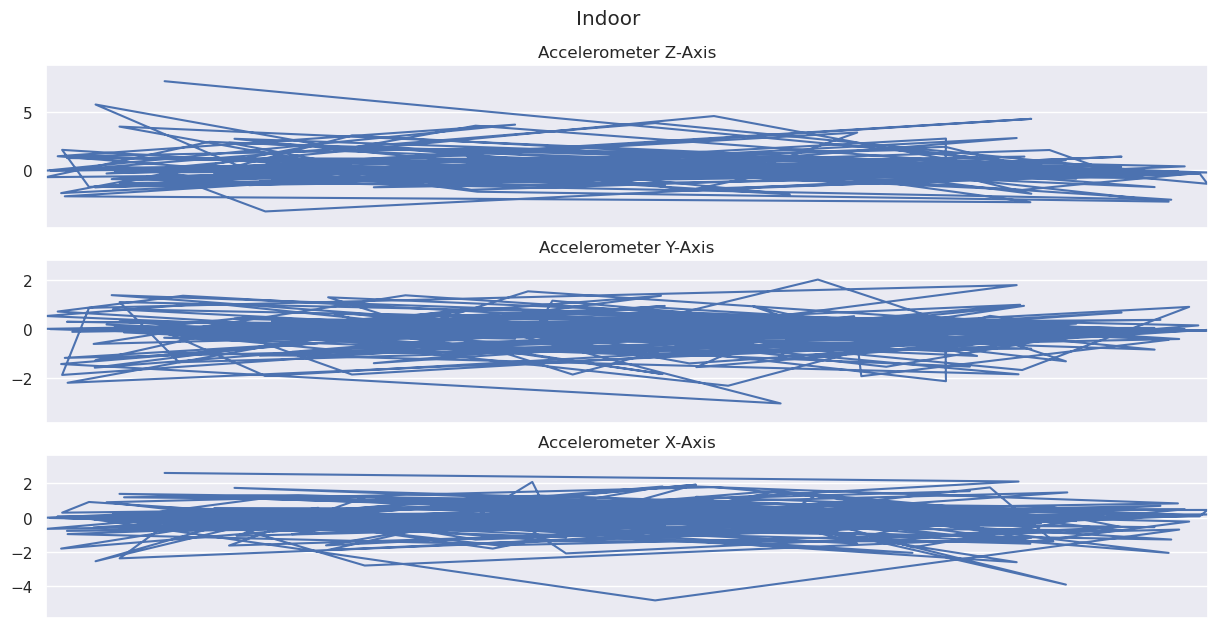

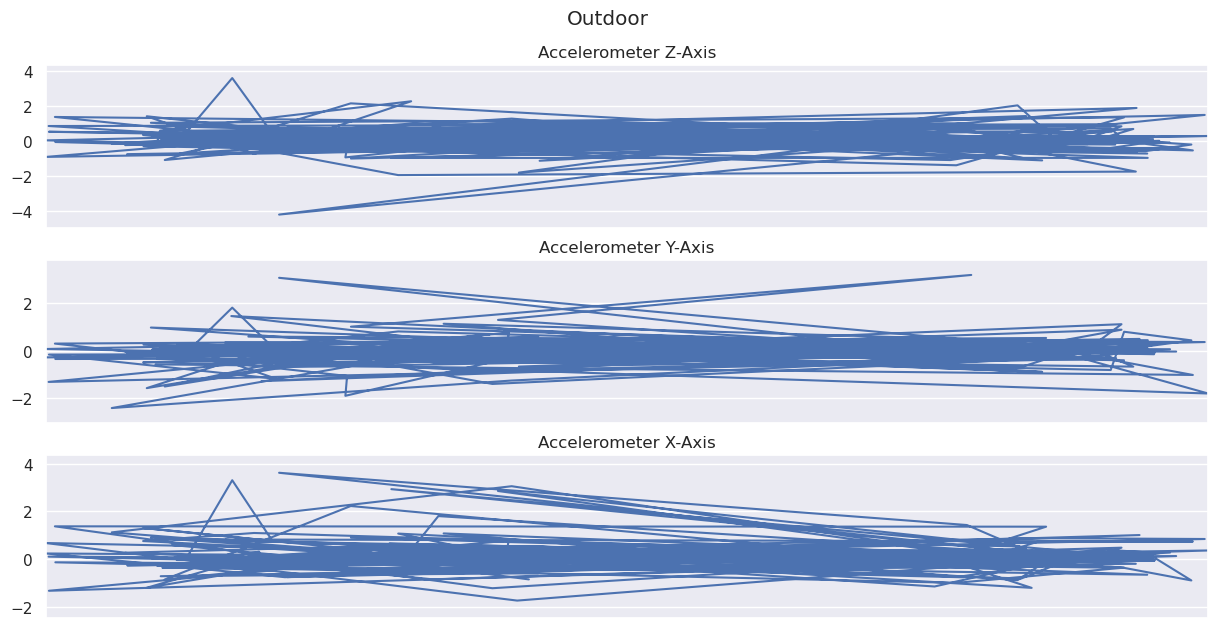

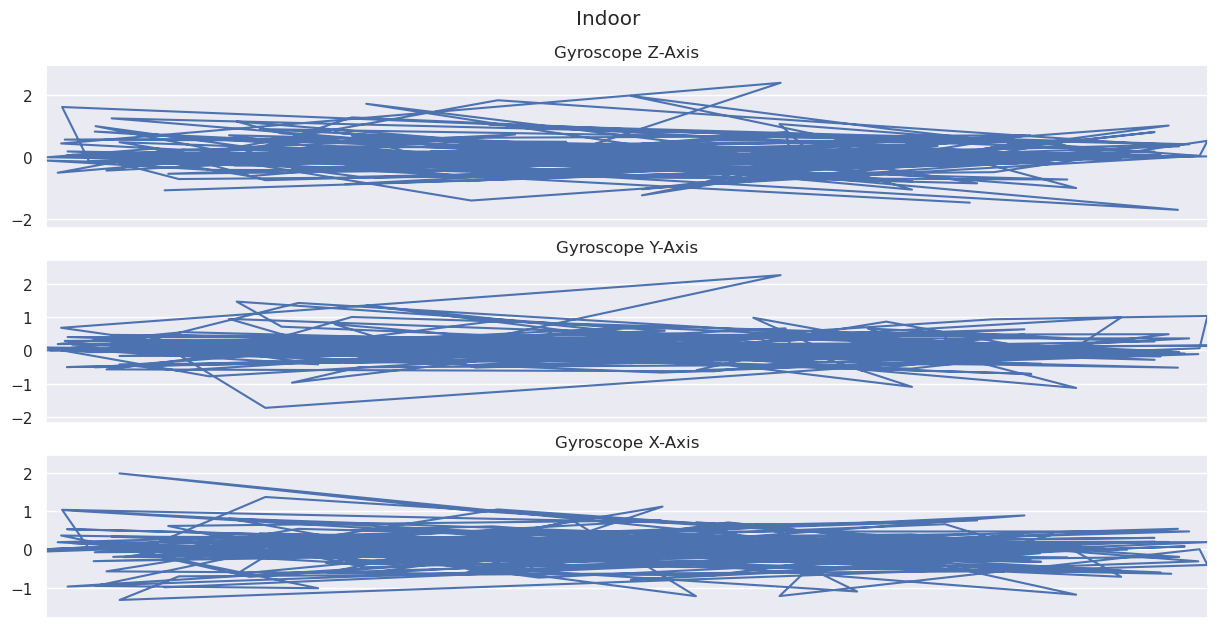

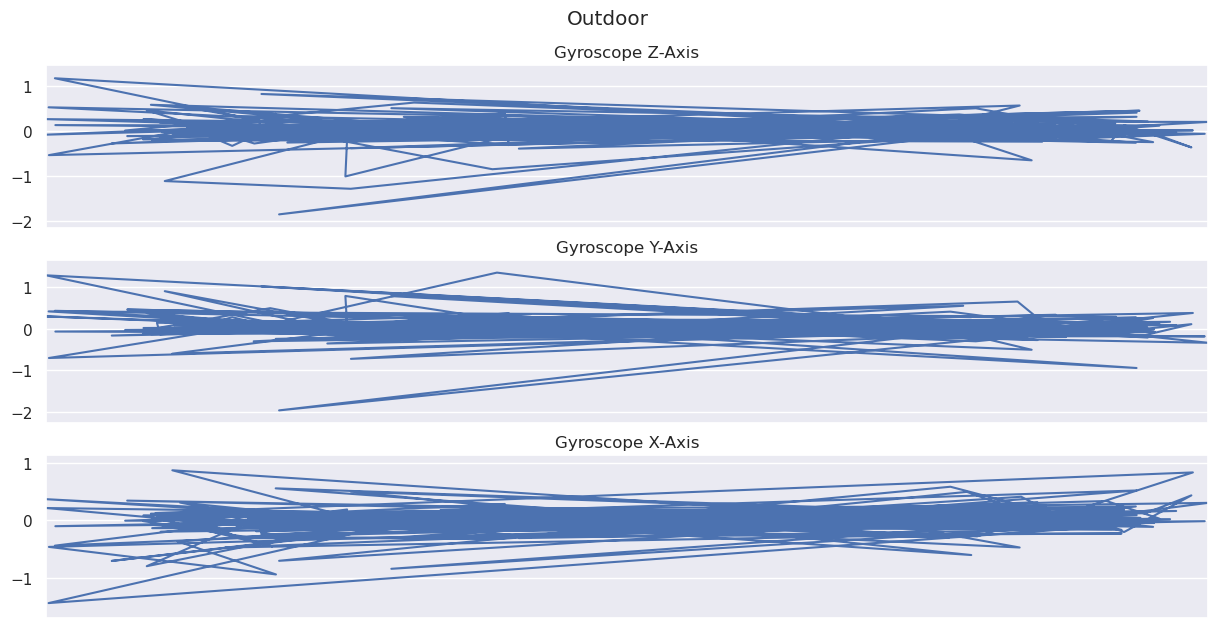

In [69]:
def plot_state(state, data):
    fig, (mx0, mx1, mx2) = plt.subplots(nrows=3, figsize=(15, 7), sharex=True)
    plot_axis(mx0, data['index'], data['mag-z'], 'Magnetometer Z-Axis')
    plot_axis(mx1, data['index'], data['mag-y'], 'Magnetometer Y-Axis')
    plot_axis(mx2, data['index'], data['mag-x'], 'Magnetometer X-Axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(state)
    plt.subplots_adjust(top=0.90)
    plt.show()

   

def plot_axis(mx, x, y, title):
    mx.plot(x, y, 'b')
    mx.set_title(title)
    mx.xaxis.set_visible(False)
    mx.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    mx.set_xlim([min(x), max(x)])
    mx.grid(True)

for state in states:
    data_for_plot = data[(data['state'] == state)][:Fs*10]
    plot_state(state, data_for_plot)

def plot_state(state, data):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(15, 7), sharex=True)
    plot_axis(ax0, data['index'], data['acc-z'], 'Accelerometer Z-Axis')
    plot_axis(ax1, data['index'], data['acc-y'], 'Accelerometer Y-Axis')
    plot_axis(ax2, data['index'], data['acc-x'], 'Accelerometer X-Axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(state)
    plt.subplots_adjust(top=0.90)
    plt.show()

   

def plot_axis(ax, x, y, title):
    ax.plot(x, y, 'b')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

for state in states:
    data_for_plot = data[(data['state'] == state)][:Fs*10]
    plot_state(state, data_for_plot)

def plot_state(state, data):
    fig, (gx0, gx1, gx2) = plt.subplots(nrows=3, figsize=(15, 7), sharex=True)
    plot_axis(gx0, data['index'], data['gyro-z'], 'Gyroscope Z-Axis')
    plot_axis(gx1, data['index'], data['gyro-y'], 'Gyroscope Y-Axis')
    plot_axis(gx2, data['index'], data['gyro-x'], 'Gyroscope X-Axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(state)
    plt.subplots_adjust(top=0.90)
    plt.show()

   

def plot_axis(mx, x, y, title):
    mx.plot(x, y, 'b')
    mx.set_title(title)
    mx.xaxis.set_visible(False)
    mx.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    mx.set_xlim([min(x), max(x)])
    mx.grid(True)

for state in states:
    data_for_plot = data[(data['state'] == state)][:Fs*10]
    plot_state(state, data_for_plot)

Here the MAGNET dataset has an un-equal nuber of values is each label. Hence we need to balance the dataset, otherwise their is a possibility of overfitting for certain labels or low accuracy for certain labels.

###  Balancing the Dataset

As observed "Indoor" has the most values, whereas the label "Outdoor" has the least

In [70]:
df = data.drop(['index', 'timestamp'], axis = 1).copy()
df['state'].value_counts()

Indoor     629667
Outdoor    477843
Name: state, dtype: int64

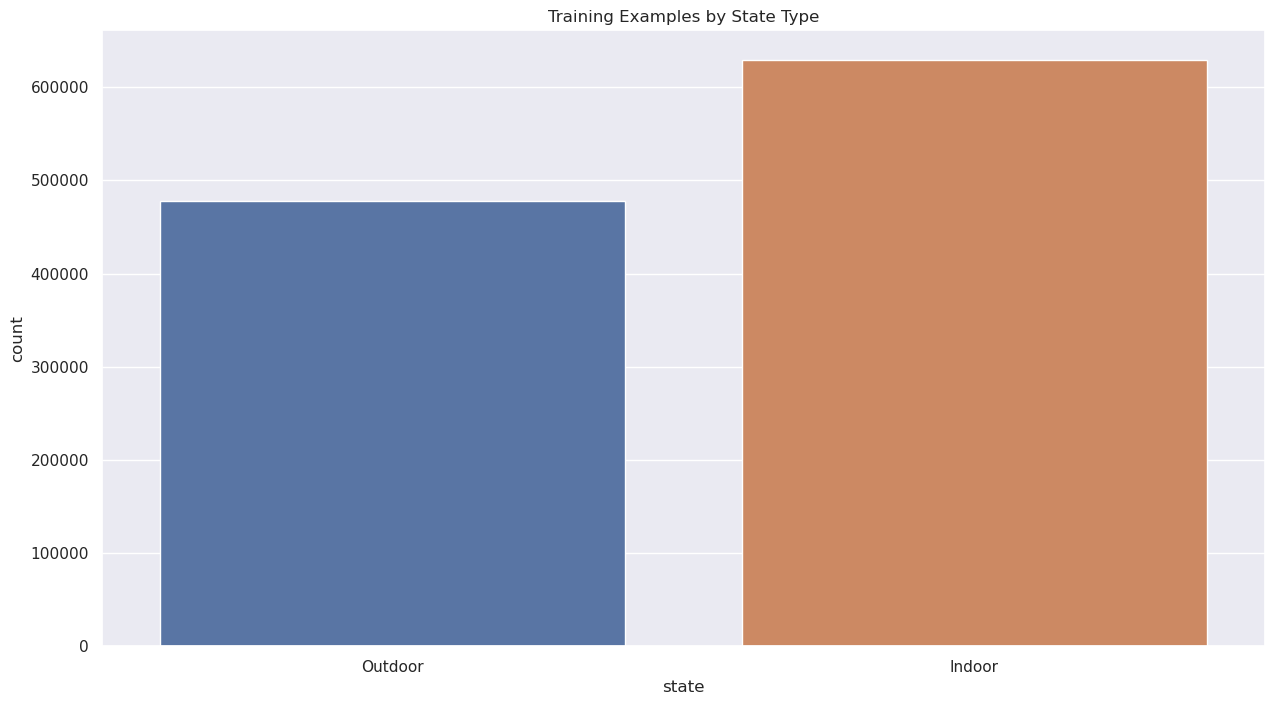

In [71]:
# Analyzing Class Label Distribution
sns.set_style('whitegrid')
sns.set(rc = {'figure.figsize':(15,8)})
sns.countplot(x = 'state', data = df)
plt.title('Training Examples by State Type')
plt.show()

Since "Outdoor" has the least quantity of data, we have taken it as a reference for balancing 

In [72]:
#Outdoor = df[df['state'] == 'Outdoor'].copy()
#Indoor = df[df['state'] == 'Indoor'].head(530828).copy()

In [73]:
value_counts = df['state'].value_counts()

# Find the minimum count of both labels
min_count = min(value_counts)

# Filter the DataFrame for 'Outdoor' and 'Indoor' categories
Outdoor = df[df['state'] == 'Outdoor'].head(min_count).copy()
Indoor = df[df['state'] == 'Indoor'].head(min_count).copy()



In [74]:
balanced_data = pd.DataFrame()
balanced_data = balanced_data.append([Outdoor, Indoor])
balanced_data.shape

(955686, 10)

In [75]:
# Displaying the balanced data
print('State Count:',balanced_data['state'].value_counts())

State Count: Outdoor    477843
Indoor     477843
Name: state, dtype: int64


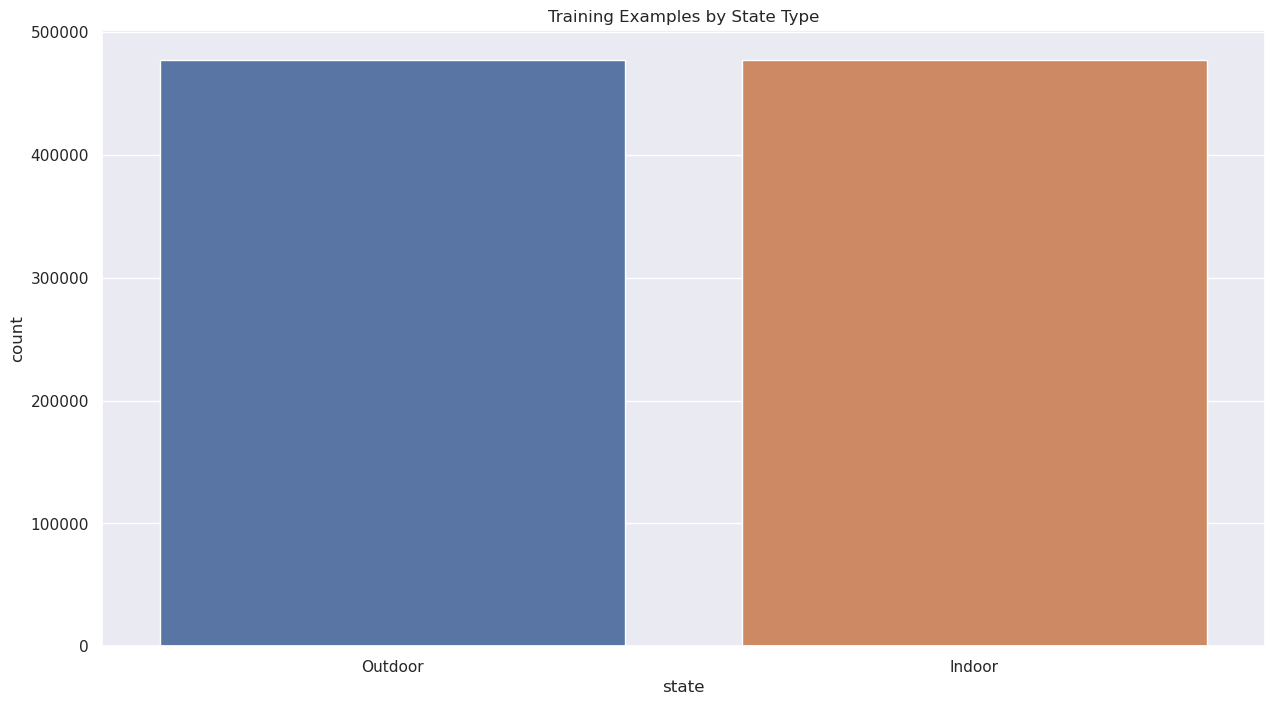

In [76]:
# Analyzing Class Label Distribution
sns.set_style('whitegrid')
sns.set(rc = {'figure.figsize':(15,8)})
sns.countplot(x = 'state', data = balanced_data)
plt.title('Training Examples by State Type')
plt.show()

In [77]:
# Encoding the Data with suitable labels
label = LabelEncoder()
balanced_data['label'] = label.fit_transform(balanced_data['state'])
balanced_data.head()

,state,mag-z,mag-y,mag-x,acc-z,acc-y,acc-x,gyro-z,gyro-y,gyro-x,label
0,Outdoor,-16.331251,13.443750,-1.912500,0.965152,-0.325462,-0.137631,0.057878,0.280684,-0.089413,1
3,Outdoor,-14.287500,-39.225002,-23.550001,0.866144,-1.319489,0.095231,0.520442,0.410642,-1.430452,1
7,Outdoor,6.750000,4.481250,18.131250,-0.428471,0.164813,-0.226860,0.110334,-0.103768,0.022525,1
8,Outdoor,-17.362501,-48.206253,6.243750,-0.048902,-0.354812,-0.142820,0.125224,-0.072004,-0.100561,1
10,Outdoor,-0.318750,-7.837500,18.712502,-1.377650,-0.295497,-1.004834,-0.071316,0.030466,0.086206,1


### Standardizing the Dataset

In [78]:
X = balanced_data[['mag-z','mag-y','mag-x','acc-z','acc-y','acc-x','gyro-z','gyro-y','gyro-x']]
y = balanced_data['label']

scaler = StandardScaler()
X = scaler.fit_transform(X)

scaled_X = pd.DataFrame(data = X, columns = ['mag-z','mag-y','mag-x','acc-z','acc-y','acc-x','gyro-z','gyro-y','gyro-x'])
scaled_X['label'] = y.values

scaled_X

,mag-z,mag-y,mag-x,acc-z,acc-y,acc-x,gyro-z,gyro-y,gyro-x,label
0,-0.309213,1.080721,0.055120,0.872185,-0.310488,-0.156126,0.126114,0.705585,-0.233058,1
1,-0.223049,-1.420259,-0.841097,0.777905,-1.630532,0.112766,1.176924,1.035918,-3.612371,1
2,0.663887,0.655136,0.885325,-0.454889,0.340586,-0.259161,0.245280,-0.271634,0.049016,1
3,-0.352691,-1.846735,0.392949,-0.093445,-0.349464,-0.162118,0.279104,-0.190895,-0.261150,1
4,0.365870,0.070179,0.909400,-1.358742,-0.270695,-1.157508,-0.167377,0.069568,0.209487,1
...,...,...,...,...,...,...,...,...,...,...
955681,-0.804854,-1.426492,-0.208154,-0.395221,0.539695,-0.124407,0.331142,0.174762,-0.413732,0
955682,-0.931334,-0.388349,1.356732,1.949831,1.066404,-1.853644,3.363710,-6.167944,3.837010,0
955683,-0.948725,-0.288630,-0.884588,-1.695355,-0.780291,1.185845,0.165142,1.451454,-0.673102,0
955684,-1.184292,-0.066044,-1.032145,0.366419,1.448638,-1.165022,1.813688,1.667277,0.932375,0


In [79]:
def get_frames_old(df, frame_size, hop_size, n_features=9):

    N_FEATURES = n_features

    frames = []
    labels = []
    for i in range(0, len(df) - frame_size, hop_size):
        mag_z = df['mag-z'].values[i: i + frame_size]
        mag_y = df['mag-y'].values[i: i + frame_size]
        mag_x = df['mag-x'].values[i: i + frame_size]
        acc_z = df['acc-z'].values[i: i + frame_size]
        acc_y = df['acc-y'].values[i: i + frame_size]
        acc_x = df['acc-x'].values[i: i + frame_size]
        gyro_z = df['gyro-z'].values[i: i + frame_size]
        gyro_y = df['gyro-y'].values[i: i + frame_size]
        gyro_x = df['gyro-x'].values[i: i + frame_size]
        
        # Retrieve the most often used label in this segment
        label = stats.mode(df['label'][i: i + frame_size])[0][0]
        frames.append([mag_z, mag_y, mag_x, acc_z, acc_y, acc_x, gyro_z, gyro_y, gyro_x])
        labels.append(label)

    # Bring the segments into a better shape
    frames = np.asarray(frames).reshape(-1, frame_size, N_FEATURES)
    labels = np.asarray(labels)

    return frames, labels

In [86]:
# Function to create overlapping frames from the data
def get_frames(df, frame_size, hop_size, n_features=8):
    N_FEATURES = n_features

    frames = []
    labels = []
    for i in range(0, len(df) - frame_size, hop_size):
        # Get each feature for the current frame
        features = [df[feature].values[i: i + frame_size] for feature in df.columns[:-1]]

        # Retrieve the most often used label in this segment
        label = stats.mode(df['state'][i: i + frame_size])[0][0]
        frames.append(features)
        labels.append(label)

    # Bring the segments into a better shape
    frames = np.asarray(frames).reshape(-1, frame_size, N_FEATURES)
    labels = np.asarray(labels)

    return frames, labels



In [80]:
frame_size = window_size
hop_size = int(frame_size / 2)


In [81]:
scaled_X = scaled_X.dropna().reset_index(drop=True)
X, y = get_frames(scaled_X, frame_size, hop_size, input_features )
X.shape, y.shape

((358380, 6, 8), (318560,))

In [82]:
scaled_X.shape

(955686, 10)

In [83]:
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)


Shape of X: (358380, 6, 8)
Shape of y: (318560,)


In [85]:
# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

# Creating the K-fold cross-validation iterator
kfold = StratifiedKFold(n_splits=fold_number, shuffle=True, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

ValueError: Found input variables with inconsistent numbers of samples: [358380, 318560]

In [ ]:
#import numpy as npt
#npt.savetxt('X_test.csv', X_test.reshape(X_test.shape[0], -1), delimiter=',')
#npt.savetxt('y_test.csv', y_test, delimiter=',')


In [ ]:
from keras.layers import Input


n_timesteps = X_train.shape[1]
n_features = X_train.shape[2]
n_outputs = 2#y_train.shape[1]

input_shape=(n_timesteps,n_features)
inputs = Input(shape=input_shape)

print("input_shape = ",input_shape)
print("n_outputs = ",n_outputs)

input_shape =  (80, 9)
n_outputs =  2


<h2><b>Propose MAGNET Model</h2></b>

In [ ]:
# Define the CNN-LSTM model with 2 parallel 1D CNN branches
def parallel_CNN_LSTM(input_shape, n_outputs):
    inputs = Input(shape=input_shape)

    # First 1D CNN branch
    x1 = Conv1D(64, kernel_size=3, activation='relu')(inputs)
    x1 = MaxPooling1D(2)(x1)
    x1 = LSTM(64)(x1)

    # Second 1D CNN branch
    x2 = Conv1D(64, kernel_size=5, activation='relu')(inputs)
    x2 = MaxPooling1D(2)(x2)
    x2 = LSTM(64)(x2)

    # Concatenate the outputs from both branches
    x = concatenate([x1, x2])

    x = Dropout(0.2)(x)
    outputs = Dense(n_outputs, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

## Training the Model

In [ ]:
# Function to train the model using K-fold cross-validation
def trainingModel(model_path, X, y, fold_number=6, epoch_number=100, batch_number=64):
    # Create KFold instance
    kfold = KFold(n_splits=fold_number, shuffle=True)

    # Create empty lists to store the fold models and evaluation results
    fold_models = []
    fold_test_acc = []
    fold_test_f1 = []
    fold_prediction_times = []
    fold_training_times = []

    # Looping over the folds
    for fold, (train_index, val_index) in enumerate(kfold.split(X, y)):
        print(f"Fold {fold+1}:")

        # Get the train and validation sets for this fold
        X_train_fold, X_val_fold = X[train_index], X[val_index]
        y_train_fold, y_val_fold = y[train_index], y[val_index]

        # Define the filepath for the saved model specific to this fold
        filepath = model_path + f"bd_MAGNet_V{version}_W_{window_size}_F_{fold+1}.h5"

        # Define early stopping based on validation loss
        early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

        # Define a checkpoint to monitor the validation accuracy and save the best model
        checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

        input_shape = X_train[0].shape
        # Create the CNN-LSTM model with parallel 1D CNNs
        model = parallel_CNN_LSTM(input_shape, outputs_class)

        # Compile the model
        optimizer = Adam(learning_rate=0.001)
        model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

        # Start the training time measurement
        start_time = time.time()

        # Train the model with the checkpoint callback for this fold
        history = model.fit(X_train_fold, y_train_fold, epochs=epoch_number, batch_size=batch_number,
                            validation_data=(X_val_fold, y_val_fold), callbacks=[checkpoint, early_stop], verbose=1)

        # End the training time measurement
        end_time = time.time()
        training_time = end_time - start_time

        # Save the fold model to the list
        fold_models.append(model)

        # Evaluate the model on the test set
        test_pred = model.predict(X_test)
        test_pred_labels = np.argmax(test_pred, axis=1)

        if len(y_test.shape) > 1 and y_test.shape[1] > 1:
            test_true_labels = np.argmax(y_test, axis=1)
        else:
            test_true_labels = y_test

        test_acc = accuracy_score(test_true_labels, test_pred_labels)
        test_f1 = f1_score(test_true_labels, test_pred_labels, average='weighted')

        # Calculate the prediction time
        start_time = time.time()
        model.predict(X_test[:1])
        end_time = time.time()
        prediction_time = (end_time - start_time) * 1000  # Convert to milliseconds

        # Save the evaluation results and times to the lists
        fold_test_acc.append(test_acc)
        fold_test_f1.append(test_f1)
        fold_prediction_times.append(prediction_time)
        fold_training_times.append(training_time)

    # Calculate mean and median times for prediction and training
    mean_prediction_time = np.mean(fold_prediction_times) / 1000  # Convert back to seconds
    median_prediction_time = np.median(fold_prediction_times) / 1000  # Convert back to seconds
    mean_training_time = np.mean(fold_training_times)
    median_training_time = np.median(fold_training_times)

    # Calculate the total number of parameters
    total_params = model.count_params()

    # Convert the total number of parameters to kilobytes (KB)
    total_params_kb = total_params / 1024  # 1 KB = 1024 bytes

    # Convert the total number of parameters to megabytes (MB)
    total_memory_mb = total_params * 4 / (1024 * 1024)  # Assuming float32 precision (4 bytes per parameter)

    # Save the averaged model
    averaged_model = fold_models[0]
    averaged_weights = averaged_model.get_weights()

    n_splits = fold_number
    # Loop over the layers of the models and average the weights
    for layer in range(len(averaged_weights)):
        for fold in range(1, n_splits):
            averaged_weights[layer] += fold_models[fold].get_weights()[layer]

        averaged_weights[layer] /= n_splits

    # Set the averaged weights to the averaged model
    averaged_model.set_weights(averaged_weights)
    averaged_filepath = model_path + f"bd_MAGNet_V{version}_W_{window_size}.h5"
    averaged_model.save(averaged_filepath)

    return averaged_model, fold_test_acc, fold_test_f1, mean_prediction_time, median_prediction_time, mean_training_time, median_training_time, total_memory_mb, total_params_kb


In [ ]:
# Train the model and get the required outputs
trained_model, test_acc, test_f1, mean_prediction_time, median_prediction_time, mean_training_time, median_training_time, total_memory_mb, total_params_kb = trainingModel(model_Path, X_train, y_train)


## Display the Results

In [ ]:
print(f"Accuracy: {test_acc}")
print(f"F1-score: {test_f1}")
print(f"Mean Prediction Time (sec): {mean_prediction_time:.6f}")
print(f"Median Prediction Time (sec): {median_prediction_time:.6f}")
print(f"Mean Training Time (sec): {mean_training_time:.6f}")
print(f"Median Training Time (sec): {median_training_time:.6f}")
print(f"Mean Single Prediction Time (msec): {mean_prediction_time * 1000:.3f}")
print(f"Median Single Prediction Time (msec): {median_prediction_time * 1000:.3f}")
print(f"Mean Required Memory (Mb): {total_memory_mb:.4f}")
print(f"Median Required Memory (Mb): {total_memory_mb:.4f}")
print(f"Mean Model Parameters (K): {total_params_kb:.2f}")
print(f"Median Model Parameters (K): {total_params_kb:.2f}")

## Confusion Matrix

In [ ]:
# Function to draw the confusion matrix and ROC curve
def drawConfusionMatrix(myModel, X_test, y_test):
    class_labels = ['Outdoor', 'Indoor']
    # Measure the time it takes to predict a single sample
    start_time = time.time()
    predict_x = myModel.predict(X_test)
    end_time = time.time()

    # Calculate the prediction time
    prediction_time = end_time - start_time
    print('Prediction time:', prediction_time, 'seconds')

    y_pred = np.argmax(predict_x, axis=1)
    mat = confusion_matrix(y_test, y_pred)
    sns.heatmap(mat, xticklabels=class_labels, yticklabels=class_labels, annot=True, linewidths=0.1, fmt='d', cmap='YlGnBu')
    plt.title("Confusion matrix", fontsize=15)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Calculate ROC curve and AUC
    y_prob = predict_x[:, 1]  # Probability for the positive class (Indoor)
    fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label=1)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
# Display confusion matrix and ROC curve
drawConfusionMatrix(trained_model, X_test, y_test)

In [ ]:
from keras.models import load_model

# Load the saved model
saved_model = load_model(model_Path + 'trainedModel_MAGNET_CNN_LSTM_V1.h5')

# Evaluate the model on the test set
test_loss, test_acc = saved_model.evaluate(X_test, y_test, verbose=0)

print('Test accuracy:', test_acc)


Test accuracy: 0.9561039805412292


In [ ]:
def plot_learningCurve(history, epochs):
  # Plot training & validation accuracy values
  epoch_range = range(1, epochs+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

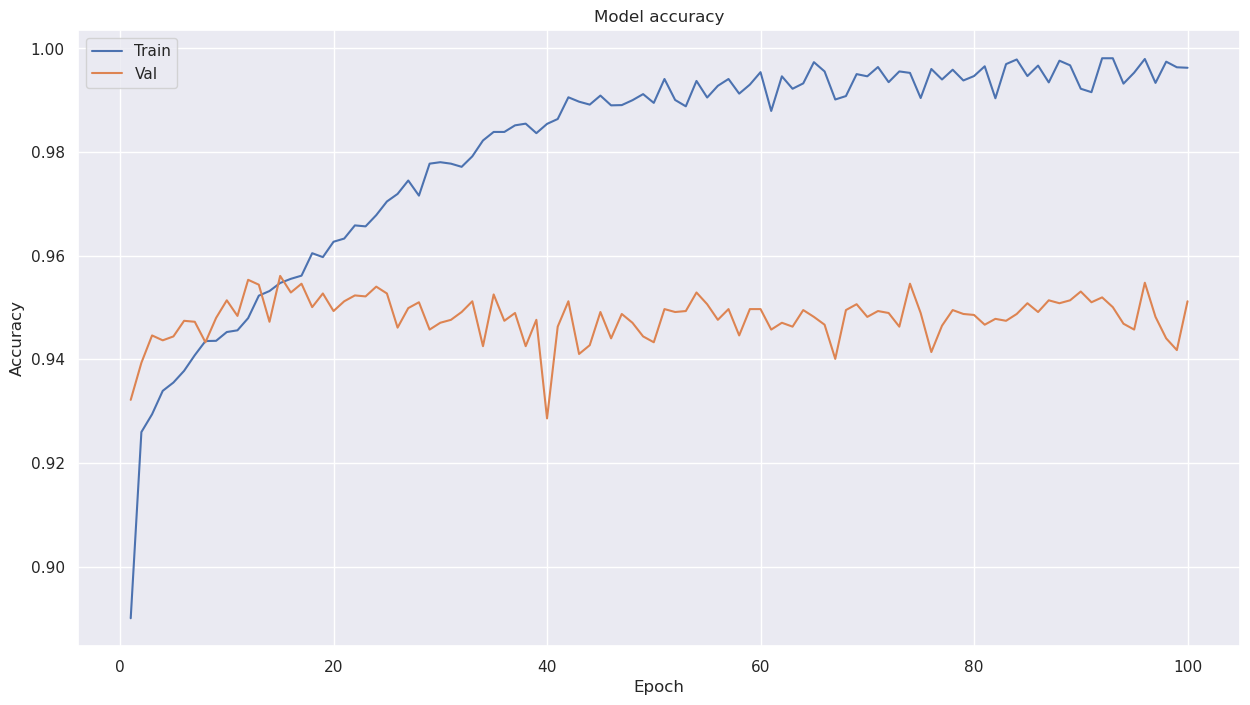

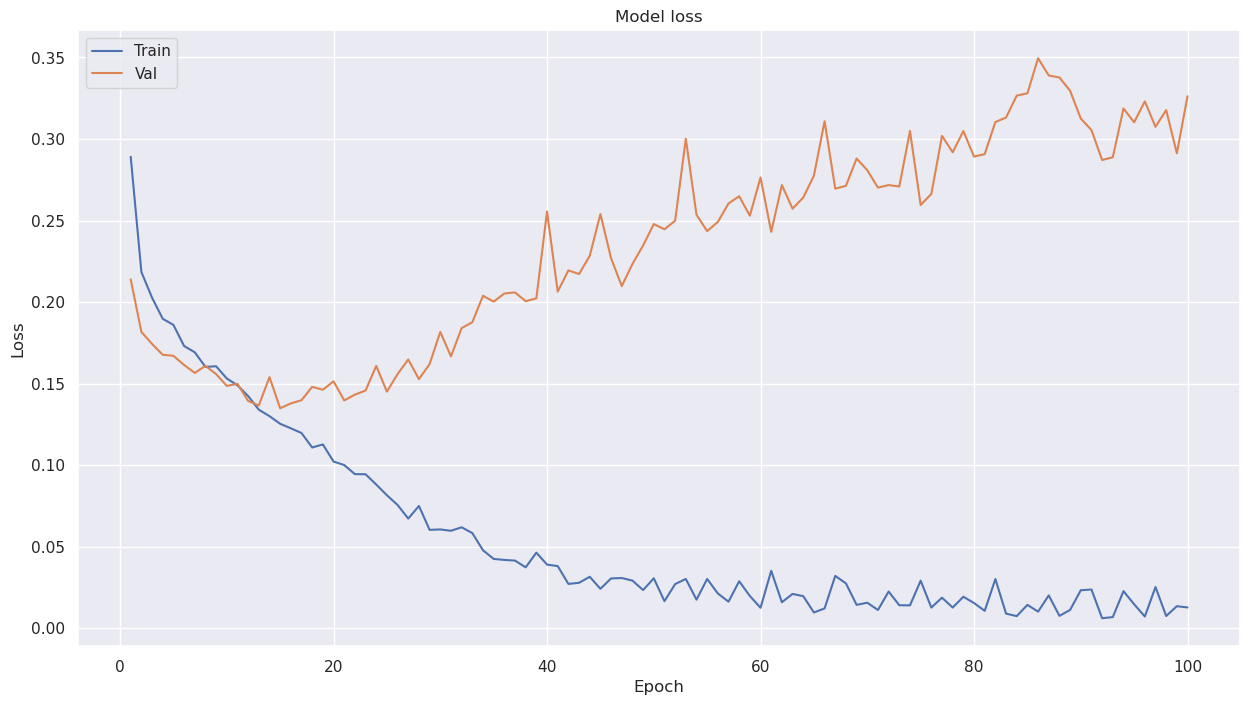

In [ ]:
plot_learningCurve(history, epochSize)

<h2><b>Results</b></h2>

### Confusion Matrix

166/166 [==============================] - 1s 5ms/step
Prediction time: 1.0572881698608398 seconds


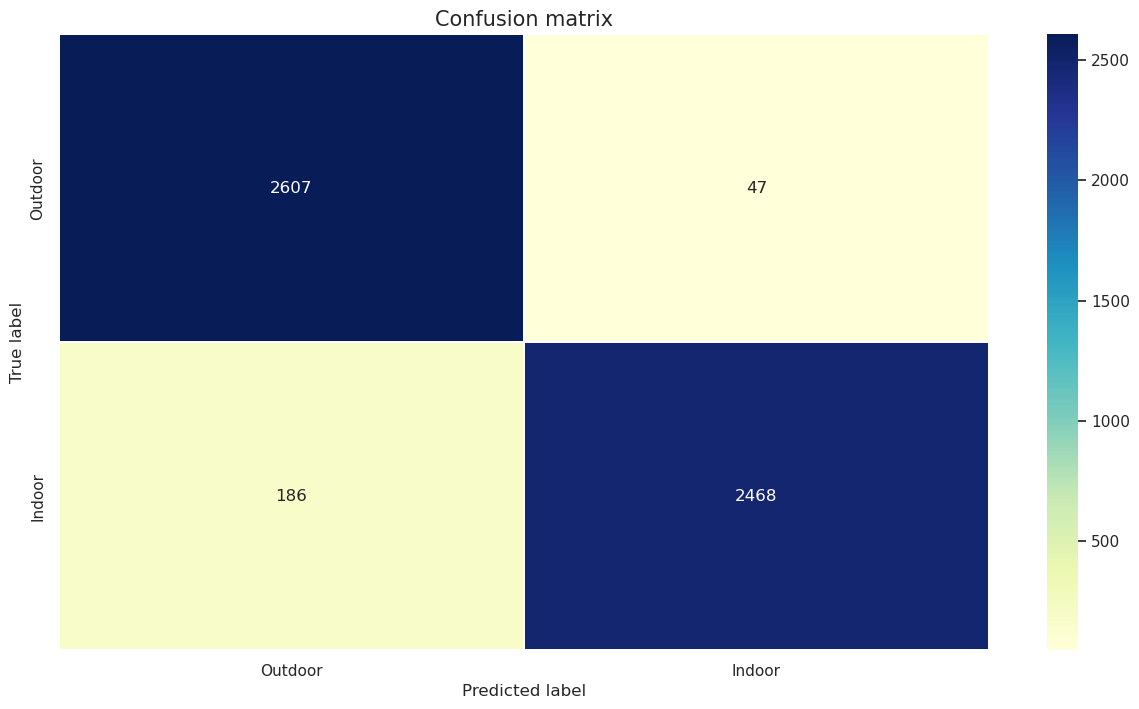

In [ ]:
import time
class_labels = ['Outdoor', 'Indoor']
# Measure the time it takes to predict a single sample
start_time = time.time()
predict_x=saved_model.predict(X_test)
end_time = time.time()

# Calculate the prediction time
prediction_time = end_time - start_time

print('Prediction time:', prediction_time, 'seconds')

# y_pred = model.predict_classes(X_test)
y_pred=np.argmax(predict_x,axis=1)
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat, xticklabels = class_labels, yticklabels = class_labels, annot = True, linewidths = 0.1, fmt='d', cmap = 'YlGnBu')
plt.title("Confusion matrix", fontsize = 15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
#plot_confusion_matrix(conf_mat=mat, classes = label.classes_, show_normed=True, figsize=(7,7))


### Classification Report

In [ ]:
results = precision_recall_fscore_support(y_test, y_pred, average='macro')

In [ ]:
print("The Testing Accuracy of the model:            {} %".format(accuracy_score(y_test, y_pred)*100))
print(f'\nThe Precision of the given model is:   {results[0]*100} %')
print(f'\nThe Recall of the given model is:      {results[1]*100} %')
print(f'\nThe F1-score of the given model is:    {results[2]*100} %')

The Testing Accuracy of the model:            95.6103993971364 %

The Precision of the given model is:   95.73585340801593 %

The Recall of the given model is:      95.6103993971364 %

The F1-score of the given model is:    95.6073871493084 %


<h2><b>Lite Version</h2></b>

## Load Trained Model 

In [ ]:
from keras.models import load_model
import numpy as np
import time
# Load the saved model
trained_model = load_model(model_Path + 'trainedModel_MAGNET_CNN_LSTM_V1.h5')

# Load Test Data 
X_test = np.loadtxt('X_test.csv', delimiter=',').reshape((-1,80,9))
y_test = np.loadtxt('y_test.csv',delimiter=',')

# Evaluate the model on the test set
test_loss, test_acc = trained_model.evaluate(X_test, y_test, verbose=0)

print('Test accuracy:', test_acc)

# Measure the time it takes to predict a single sample
start_time = time.time()
predict_x = trained_model.predict(X_test)
end_time = time.time()

# Calculate the prediction time
prediction_time = end_time - start_time

print('Prediction time:', prediction_time, 'seconds')


Test accuracy: 0.9561039805412292
166/166 [==============================] - 1s 5ms/step
Prediction time: 1.0398643016815186 seconds


In [ ]:
results = precision_recall_fscore_support(y_test, y_pred, average='macro')

In [ ]:
print("The Testing Accuracy of the model:     {} %".format(accuracy_score(y_test, y_pred)*100))
print(f'\nThe Precision of the given model is:   {results[0]*100} %')
print(f'\nThe Recall of the given model is:      {results[1]*100} %')
print(f'\nThe F1-score of the given model is:    {results[2]*100} %')

The Testing Accuracy of the model:     95.6103993971364 %

The Precision of the given model is:   95.73585340801593 %

The Recall of the given model is:      95.6103993971364 %

The F1-score of the given model is:    95.6073871493084 %


# Convert Trained Model to Lite Version

In [ ]:
import tensorflow

# Convert the model to a TFLite model
try:
    converter = tensorflow.lite.TFLiteConverter.from_keras_model(trained_model)
    tflite_model = converter.convert()
except:
    # Convert the model to a TFLite model
    converter = tensorflow.lite.TFLiteConverter.from_keras_model(trained_model)
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
    converter.experimental_new_converter = True
    converter.experimental_enable_resource_variables = True
    converter._experimental_lower_tensor_list_ops = False  # Set this flag to False
    tflite_model = converter.convert()


INFO:tensorflow:Assets written to: /tmp/tmpiy_ja746/assets


INFO:tensorflow:Assets written to: /tmp/tmpiy_ja746/assets
2023-04-24 17:44:46.501082: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-04-24 17:44:46.501114: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-04-24 17:44:46.501221: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpiy_ja746
2023-04-24 17:44:46.505791: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-04-24 17:44:46.505810: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpiy_ja746
2023-04-24 17:44:46.528636: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2023-04-24 17:44:46.573825: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpiy_ja746
2023-04-24 17:44:46.597893: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmphaf8za5g/assets


INFO:tensorflow:Assets written to: /tmp/tmphaf8za5g/assets
2023-04-24 17:44:50.139756: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-04-24 17:44:50.139784: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-04-24 17:44:50.139890: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmphaf8za5g
2023-04-24 17:44:50.144438: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-04-24 17:44:50.144453: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmphaf8za5g
2023-04-24 17:44:50.166722: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2023-04-24 17:44:50.211432: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmphaf8za5g
2023-04-24 17:44:50.235092: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

## Save Lite Version of Trained Model

In [ ]:
# Save the TFLite model to a file
with open(model_Path + 'trainedModelLite_MAGNET_CNN_LSTM_V1.tflite', 'wb') as f:
    f.write(tflite_model)

try:
    # load the model from a file
    test_load_lite_model = tf.lite.Interpreter(model_Path + 'trainedModelLite_MAGNET_CNN_LSTM_V1.tflite')
    print("Lite Version of Trained Model saved and loaded successfully !!!")
    
except:
    print("Lite Version of Trained Model is not saved successfully !!!")

Lite Version of Trained Model saved and loaded successfully !!!


INFO: Created TensorFlow Lite delegate for select TF ops.
2023-04-24 17:44:56.012955: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-24 17:44:56.013159: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
INFO: TfLiteFlexDelegate delegate: 2 nodes delegated out of 42 nodes with 2 partitions.



## Load Lite Version of Trained Model

In [ ]:
import tensorflow as tf

# Load the TensorFlow Lite model.
trained_Model_Lite_Path = model_Path + 'trainedModelLite_MAGNET_CNN_LSTM_V1.tflite'
interpreter = tf.lite.Interpreter(model_path=trained_Model_Lite_Path)
interpreter.allocate_tensors()

# Get input and output details.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Print model summary.
print('Input shape:', input_details[0]['shape'])
print('Input type:', input_details[0]['dtype'])
print('Output shape:', output_details[0]['shape'])
print('Output type:', output_details[0]['dtype'])

Input shape: [ 1 80  9]
Input type: <class 'numpy.float32'>
Output shape: [1 2]
Output type: <class 'numpy.float32'>


2023-04-24 17:44:58.711846: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-24 17:44:58.712036: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


## Evaluation of Lite Version of Trained Model 

2023-04-24 17:45:02.368174: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-24 17:45:02.368320: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Accuracy: 95.61%


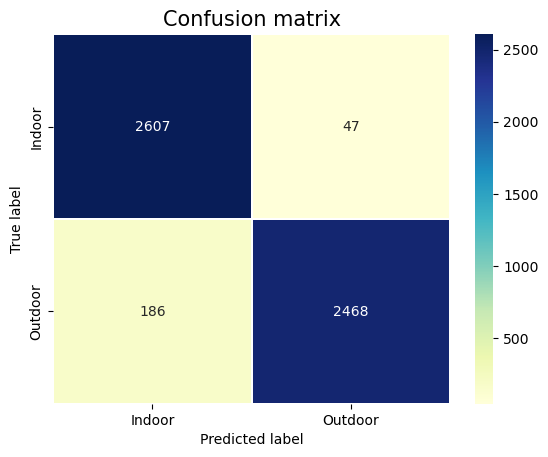

In [ ]:
import tensorflow as tf
import numpy as np
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt

# Load the TensorFlow Lite model.
interpreter = tf.lite.Interpreter(trained_Model_Lite_Path)
interpreter.allocate_tensors()

# Get the input and output details.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Load the test data.
X_test = X_test 
y_test = y_test

# Test the model on the test data.
correct = 0
y_pred = []

for i in range(len(X_test)):
    # Preprocess the input data.
    input_data = X_test[i].astype(np.float32)
    input_data = np.expand_dims(input_data, axis=0)

    # Set the input tensor.
    interpreter.set_tensor(input_details[0]['index'], input_data)

    # Run inference.
    interpreter.invoke()

    # Get the output tensor.
    output_data = interpreter.get_tensor(output_details[0]['index'])
    prediction = np.argmax(output_data)
    # Check if the prediction is correct.
    if prediction == y_test[i]:
        correct += 1
    y_pred.append(prediction)

accuracy = correct / len(X_test)
print("Accuracy: {:.2f}%".format(accuracy * 100))

# Convert y_test from one-hot encoded array to 1D array of labels.
y_test_labels = np.argmax(np.expand_dims(y_test, axis=0), axis=1)


# confusion matrix
LABELS = [
    'Indoor',
    'Outdoor'
] 
class_labels = LABELS
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat, xticklabels = class_labels, yticklabels = class_labels, annot = True, linewidths = 0.1, fmt='d', cmap = 'YlGnBu')
plt.title("Confusion matrix", fontsize = 15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()



## Comparison of Trained Model and Lite Version of Trained Model

In [ ]:
print("Comparison of Trained Model and Lite Version of Trained Model :")
test_Accuracy_Trained_Model =  (test_acc*100)
test_Accuracy_Trained_Model_Lite = accuracy * 100
print("Trained Model (Full) - Test Accuracy: %.2f%%" % (test_Accuracy_Trained_Model))
print("Trained Model (Lite) - Test Accuracy: {:.2f}%".format(test_Accuracy_Trained_Model_Lite))


Comparison of Trained Model and Lite Version of Trained Model :
Trained Model (Full) - Test Accuracy: 95.61%
Trained Model (Lite) - Test Accuracy: 95.61%
